### Plotting and Analyzing Learned Parameters of Trained BINN

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import MLPComponentsCV
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, lasso_parameter_fitting, plot_loss_convergence
import seaborn as sns
from sklearn import linear_model

# helper functions
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

def to_numpy(x):
    return x.detach().cpu().numpy()

In [24]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
population = 50000
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
mask = False
n_runs = 1000
chi_type = 'piecewise'

Device set to cpu


In [25]:
case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
if mask:
    case_name = case_name + '_masking'

In [26]:
params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)

In [27]:
data = np.array(params['data'])
data_smooth = np.mean(data, axis=0)
data_smooth = (data_smooth / params['population'])

N = len(data_smooth) - 2
u = to_torch(data_smooth[1:N+1,:])

t_max_real = N
t = np.arange(N)[:,None] + 1
params.pop('data')

tracing_array = params['tracing_array']

In [28]:
u_front = data_smooth[:N,:]
u_back = data_smooth[2:,:]
ut = to_torch((u_back - u_front) / 2.)

In [29]:
# split into train/val and convert to torch
split = int(0.8*N)
# generate shuffled array of indices from 0 to N-1
p = np.random.permutation(N)[:,None]

u_tensor = torch.cat([u[:,:,None], ut[:,:,None]], axis=2)

In [30]:
x_train = to_torch((p[:split] + 1))
# assign y_train to be values corresponding to x_train of size int(0.8 * N)
y_train = to_torch(u[(p[:split]).flatten()])
# assign x_val to be randomly shuffled days from 1 to 182 of size int(0.2 * N)
x_val = to_torch((p[split:] + 1))
# assign y_val to be values corresponding to y_val of size int(0.2 * N)
y_val = to_torch(u[(p[split:]).flatten()])

C:\Users\Teddy\AppData\Local\Temp\ipykernel_14700\1036197225.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = torch.tensor(ndarray, dtype=torch.float)


In [31]:
# mydir = '../models/covasim/debugging/2023-06-30_10-07-13'
# mydir = '../models/covasim/debugging/2023-06-30_11-47-15'
# mydir = '../models/covasim/denoised/2023-07-05_17-46-21'
# mydir = '../models/covasim/denoised/2023-07-05_22-56-42'
# mydir = '../models/covasim/denoised/2023-07-05_23-03-30'
# mydir = '../models/covasim/denoised/2023-07-06_08-58-57'
mydir = '../models/covasim/denoised/2023-07-06_09-38-51'

binn = MLPComponentsCV(params, u_tensor, N, tracing_array, keep_d=keep_d, chi_type=chi_type).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [32]:
# load model weights
# model.save_name = '../Weights/'
# model.save_name += case_name
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)
save_path = model.save_folder
# grab initial condition
u0 = data_smooth[0, :].copy()

In [33]:
# if not folder for plots exists, make them
if not os.path.exists(model.save_folder + '\\eta_plots'):
    os.makedirs(os.path.join(model.save_folder, 'eta_plots'))
    os.makedirs(os.path.join(model.save_folder, 'beta_plot'))
    os.makedirs(os.path.join(model.save_folder, 'tau_plot'))
    # os.makedirs(os.path.join(model.save_folder, 'lasso_plots'))

In [34]:
# grab value ranges
yita_lb, yita_ub = model.model.yita_lb, model.model.yita_ub
beta_lb, beta_ub = model.model.beta_lb, model.model.beta_ub
tau_lb, tau_ub = model.model.tau_lb, model.model.tau_ub

In [35]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)
# learned tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)
# learned diagnoses rate of quarantined individuals
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [36]:
#%% visualization for eta
s_min, s_max = data_smooth[:,0].min(), data_smooth[:,0].max()
a_min, a_max = data_smooth[:,3].min(), data_smooth[:,3].max()
y_min, y_max = data_smooth[:,4].min(), data_smooth[:,4].max()
say_min, say_max = (data_smooth[:,0] + data_smooth[:,3] + data_smooth[:,4]).min(), (data_smooth[:,0] + data_smooth[:,3] + data_smooth[:,4]).max()
chi_min, chi_max = 0.0, params['eff_ub']

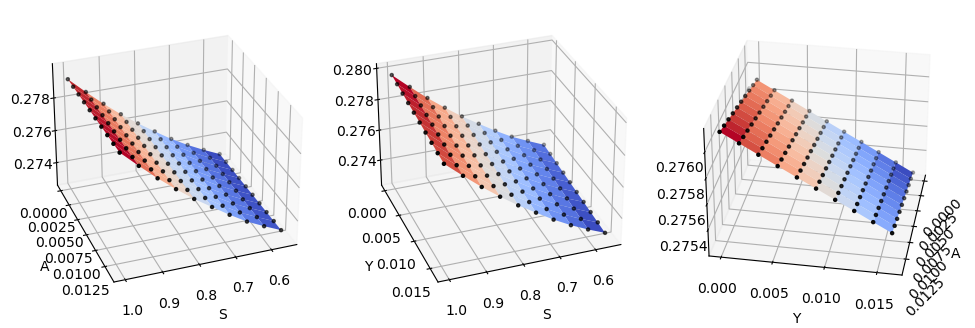

In [37]:
# grid for inputs S, A
a_grid = np.linspace(s_min, s_max, 10)
# grid for inputs S, Y
b_grid = np.linspace(a_min, a_max, 10)
# grid for inputs A, Y
c_grid = np.linspace(y_min, y_max, 10)

labels = ['S', 'A', 'Y']
fig = plt.figure(figsize=(10,7))
# for each of the 3 input combinations
for i in range(3):
    if i == 0:
        X, Y = np.meshgrid(a_grid, b_grid)
        Z = np.ones_like(X) * c_grid.mean()
        # set x and y labels to S and A
        x_label, y_label = labels[0], labels[1]
    elif i == 1:
        X, Z = np.meshgrid(a_grid, c_grid)
        Y = np.ones_like(X) * b_grid.mean()
        # set x and y labels to S and Y
        x_label, y_label = labels[0], labels[2]
    else:
        Y, Z = np.meshgrid(b_grid, c_grid)
        X = np.ones_like(Y) * a_grid.mean()
        # set x and y labels to A and Y
        x_label, y_label = labels[1], labels[2]

    # grid of S, A, Y values
    u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z)], axis=1)
    # result of evaluating eta with inputs S, A, Y
    res = contact_rate(u_grid)
    # transfom eta(S, A, Y) into the interval previously defined
    res = yita_lb + (yita_ub - yita_lb) * res
    res = res[:,0].reshape(X.shape)
    res = np.round(res, decimals=6)
    
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    if i == 0:
        ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i == 1:
        ax.plot_surface(X, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    else:
        ax.plot_surface(Y, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(Y.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        plt.setp(ax.get_xticklabels(), rotation=45) # , ha="right", rotation_mode="anchor"
        ax.view_init(30,10)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '\\eta_plots', case_name + '_parameter_NN_eta_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_14700\2878701596.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2)


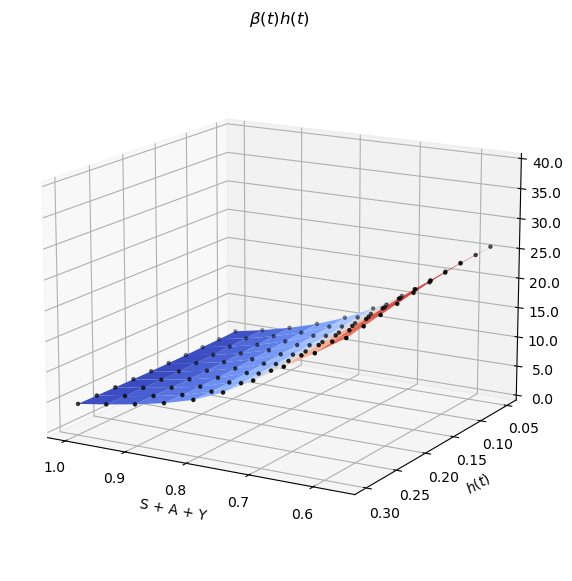

In [38]:
#%% visualization for beta
chi_min, chi_max = 0.05, params['eff_ub']
# chi_grid = np.linspace(chi_min, chi_max, 10)

a_grid = np.linspace(say_min, say_max, 10) # S + A + Y
b_grid = np.linspace(chi_min, chi_max, 10)
labels = ['S + A + Y', r'$h(t)$']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = beta(u_grid) * params['n_contacts'] # * u_grid[:, [1]] *
res = res[:,0].reshape(X.shape)
res = np.round(res, decimals=6)
# res = beta_lb + (beta_ub - beta_lb) * res

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zticks(np.arange(0,40.1, 5), np.arange(0,40.1, 5))
ax.set_title(r'$\beta(t)h(t)$')
ax.view_init(15,120)
plt.tight_layout(pad=2)

plt.savefig(os.path.join(save_path + '\\beta_plot', case_name + '_parameter_NN_beta_DRUMS' + '.png'), dpi=300, bbox_inches='tight' )
plt.show()
plt.close()

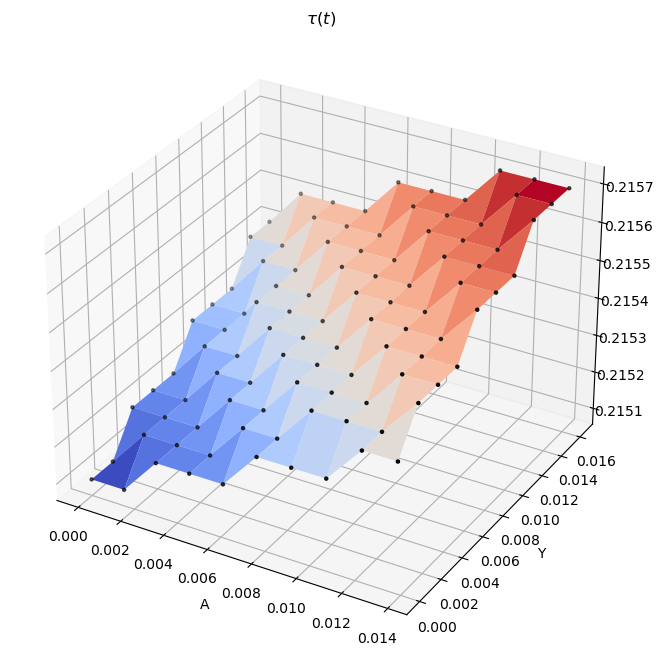

In [39]:
#%% visualization for tau

a_grid = np.linspace(a_min, a_max, 10)
b_grid = np.linspace(y_min, y_max, 10)
labels = ['A', 'Y']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = tau(u_grid)
res = res[:,0].reshape(X.shape)
res = tau_lb + (tau_ub - tau_lb) * res # scaling
res = np.round(res, decimals=4)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(r'$\tau(t)$')
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '\\tau_plot', case_name + '_parameter_NN_tau_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
total_train_losses = model.train_loss_list
total_val_losses = model.val_loss_list

plot_loss_convergence(total_train_losses, total_val_losses, rel_save_thresh, model.save_folder)